In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, Reshape, Embedding, GlobalAveragePooling1D, Lambda

2025-05-05 17:39:05.866832: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# NOT GENBANK

In [2]:
def read_csv_head(input_file, num_lines):
    """
    Đọc num_lines dòng đầu tiên từ file CSV (kể cả dòng header) và trả về dưới dạng list.
    
    :param input_file: Đường dẫn file CSV.
    :param num_lines: Số dòng muốn lấy (bao gồm header).
    :return: Danh sách các dòng đã lấy.
    """
    result = []
    with open(input_file, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for i, row in enumerate(reader):
            if i >= num_lines:
                break
            result.append(row)
    return result

In [3]:
data_namp = read_csv_head(r'/mnt/nvme1/nAMP_notGenBank.csv', 900001)  # 1 dòng tiêu đề + 2500 dòng dữ liệu
data_namp = pd.DataFrame(data_namp[1:], columns=data_namp[0])
# data_namp

In [4]:
# data_amp = pd.read_csv(r'/mnt/nvme1/AMP_GenBank.csv')
# data_amp = pd.read_csv(r'/mnt/nvme1/AMP_GenBank.csv')  # 1 dòng tiêu đề + 2500 dòng dữ liệu
# data_amp
data_amp = read_csv_head(r'/mnt/nvme1/AMP_notGenBank.csv', 900001)  # 1 dòng tiêu đề + 2500 dòng dữ liệu
data_amp = pd.DataFrame(data_amp[1:], columns=data_amp[0])

In [5]:
combinated_data = pd.concat([data_namp, data_amp], ignore_index=True)
# data

In [6]:
data, data_test = train_test_split(combinated_data, test_size=0.3, stratify=combinated_data['Label'], random_state=42, shuffle=True)

In [7]:
data = data.drop(columns=['ID'])
data_test = data_test.drop(columns=['ID'])

In [8]:
float_columns = data.select_dtypes(include=['float64']).columns
object_columns = data.select_dtypes(include=['object']).columns

In [9]:
data.loc[:, 'Label'] = data['Label'].apply(lambda x: 0 if x == 'nAMP' else 1)
data['Label'] = data['Label'].astype(float)

data_test.loc[:, 'Label'] = data_test['Label'].apply(lambda x: 0 if x == 'nAMP' else 1)
data_test['Label'] = data_test['Label'].astype(float)

# data

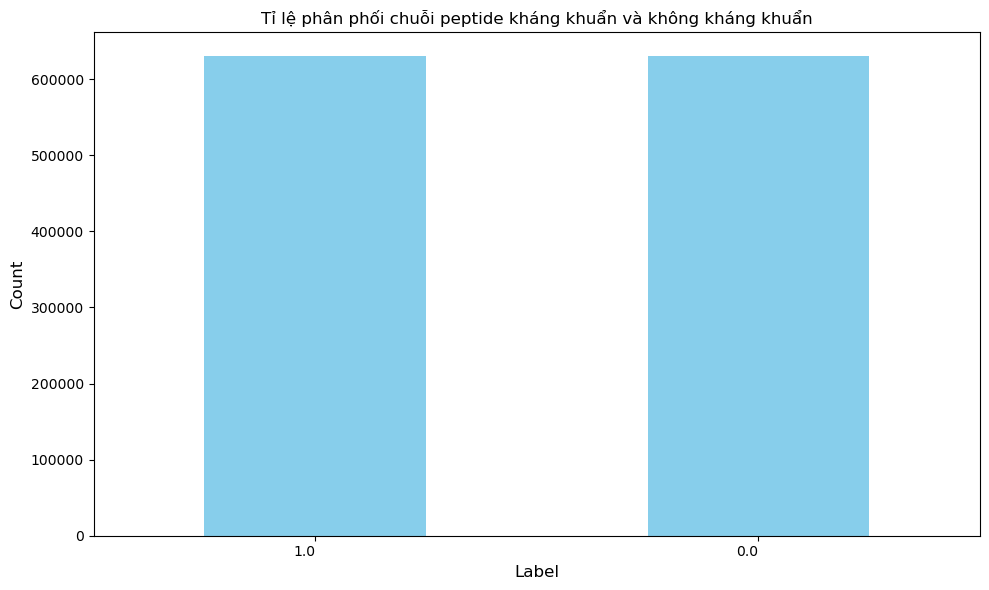

In [10]:
label_counts = data['Label'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color = 'skyblue')
plt.title('Tỉ lệ phân phối chuỗi peptide kháng khuẩn và không kháng khuẩn')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [11]:
x_test = data_test.drop(columns=['Label'])
y_test = data_test['Label']

X_train = data.drop(columns=['Label'])
y_train = data['Label']

In [12]:
X_val, X_test, Y_val, Y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=42, shuffle=True)

In [13]:
max_length = 50

padding_type = 'post' # Đệm thêm số 0
trunc_type = 'post'  # Cắt nếu chuỗi dài

In [14]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data['Sequence'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  26


In [15]:
tokenizer.word_index

{'l': 1,
 'r': 2,
 'a': 3,
 'v': 4,
 'k': 5,
 'g': 6,
 's': 7,
 'i': 8,
 't': 9,
 'p': 10,
 'f': 11,
 'q': 12,
 'n': 13,
 'e': 14,
 'y': 15,
 'd': 16,
 'm': 17,
 'h': 18,
 'w': 19,
 'c': 20,
 'x': 21,
 'b': 22,
 'j': 23,
 'z': 24,
 'u': 25}

In [16]:
train_sequences  = tokenizer.texts_to_sequences(X_train['Sequence'])
train_sequence_array = pad_sequences(train_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val['Sequence'])
val_sequence_array = pad_sequences(val_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test['Sequence'])
test_sequence_array = pad_sequences(test_sequences , maxlen= max_length, padding= padding_type, truncating=trunc_type)

In [17]:
X_train= X_train.drop(columns=['Sequence'])
X_train['train_sequences'] = train_sequence_array.tolist()

X_val= X_val.drop(columns=['Sequence'])
X_val['val_sequences'] = val_sequence_array.tolist()

X_test= X_test.drop(columns=['Sequence'])
X_test['test_sequences'] = test_sequence_array.tolist()

In [18]:
X_train_num = X_train.iloc[:, :126]  # Chọn 126 cột đầu tiên
X_train_text = X_train.iloc[:, -1]   # Chọn cột cuối cùng

In [19]:
X_val_num = X_val.iloc[:, :126]  # Chọn 126 cột đầu tiên
X_val_text = X_val.iloc[:, -1]   # Chọn cột cuối cùng

In [20]:
X_train_num = X_train_num.to_numpy(dtype=np.float32)
X_val_num = X_val_num.to_numpy(dtype=np.float32)

In [21]:
# Định nghĩa độ dài cố định cho X_train_text và X_val_text
max_len = max_length  

# Chuyển đổi tất cả thành danh sách cùng kích thước
X_train_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_train_text], dtype=np.int32)

X_val_text = np.array([seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_val_text], dtype=np.int32)

print("X_train_text shape:", X_train_text.shape)
print("X_val_text shape:", X_val_text.shape)

X_train_text shape: (1260000, 50)
X_val_text shape: (270000, 50)


In [24]:
X_train_num_notGenBank = X_train_num
X_val_num_notGenBank = X_val_num

X_train_text_notGenBank = X_train_text
X_val_text_notGenBank = X_val_text
X_test_notGenBank = X_test

y_train_notGenBank = y_train
Y_val_notGenBank = Y_val

In [22]:
Y_test_notGenBank = Y_test

In [25]:
np.save('numpy_notGenBank/X_train_num_notGenBank.npy', X_train_num_notGenBank)

In [26]:
np.save('numpy_notGenBank/X_val_num_notGenBank.npy', X_val_num_notGenBank)

In [27]:
np.save('numpy_notGenBank/X_train_text_notGenBank.npy', X_train_text_notGenBank)

In [28]:
np.save('numpy_notGenBank/X_val_text_notGenBank.npy', X_val_text_notGenBank)

In [29]:
X_test_notGenBank.to_csv('numpy_notGenBank/X_test_notGenBank.csv', index=False)

In [30]:
np.save('numpy_notGenBank/y_train_notGenBank.npy', y_train_notGenBank)

In [31]:
np.save('numpy_notGenBank/Y_val_notGenBank.npy', Y_val_notGenBank)

In [23]:
np.save('numpy_notGenBank/Y_test_notGenBank.npy', Y_test_notGenBank)

In [32]:
X_train_num_notGenBank_loaded = np.load('numpy_notGenBank/X_train_num_notGenBank.npy')
X_train_num_notGenBank_loaded.shape

(1260000, 126)

In [33]:
X_val_num_notGenBank_loaded = np.load('numpy_notGenBank/X_val_num_notGenBank.npy')
X_val_num_notGenBank_loaded.shape

(270000, 126)

In [34]:
X_train_text_notGenBank_loaded = np.load('numpy_notGenBank/X_train_text_notGenBank.npy')
X_train_text_notGenBank_loaded.shape

(1260000, 50)

In [35]:
X_val_text_notGenBank_loaded = np.load('numpy_notGenBank/X_val_text_notGenBank.npy')
X_val_text_notGenBank_loaded.shape

(270000, 50)

In [36]:
X_test_notGenBank_loaded = pd.read_csv('numpy_notGenBank/X_test_notGenBank.csv')
X_test_notGenBank_loaded.shape

(270000, 127)

In [37]:
y_train_notGenBank_loaded = np.load('numpy_notGenBank/y_train_notGenBank.npy')
y_train_notGenBank_loaded.shape

(1260000,)

In [38]:
Y_val_notGenBank_loaded = np.load('numpy_notGenBank/Y_val_notGenBank.npy')
Y_val_notGenBank_loaded.shape

(270000,)

In [24]:
Y_test_notGenBank_loaded = np.load('numpy_notGenBank/Y_test_notGenBank.npy')
Y_test_notGenBank_loaded.shape

(270000,)